[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/refactor/scripts/interactive/example_what_if.ipynb)

In [ ]:
!pip install covid19_inference



# Example: What-if scenarios
Create different scenarios on what may be the effect of a (future) change point
Non-hierarchical model using jhu data (no regions).

Runtime ~ 15 min

At the end we also show how to plot with German labels.


In [1]:
import datetime
import copy
import sys

In [2]:
import pymc as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

In [4]:
# limit the data range
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 5, 14)

In [5]:
# download data
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Germany", data_begin=bd, data_end=ed)

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


In [6]:
# set model parameters
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=28,
    diff_data_sim=16,
    N_population=83e6,
)

In [7]:
# change points like in the paper
cp_base = [
    # mild distancing
    dict(
        # account for new implementation where transients_day is centered, not begin
        pr_mean_date_transient=datetime.datetime(2020, 3, 10),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
    ),
    # strong distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 17),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
    ),
    # contact ban
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 24),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=0.5,
    ),
]



Scenarios for May 11, due to ~11 days delay, not evident in data yet
Add additional change points with reference to the previous values.

We use a value as reference that we inferred in a previous run (as of May 14)

In [8]:
ref = 0.10
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [9]:
# a: double the contacts (this only effectively applies apart from family)
cp_a = copy.deepcopy(cp_base)
cp_a.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref * 2,
        pr_sigma_lambda=0.3,
    )
)

In [10]:
# b: back to pre-lockdown value
cp_b = copy.deepcopy(cp_base)
cp_b.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=0.15,
        pr_sigma_lambda=0.3,
    )
)

In [11]:
# c: 20% decrease, ideal case, for instance if contact tracing is very effective
cp_c = copy.deepcopy(cp_base)
cp_c.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref - ref * 0.2,
        pr_sigma_lambda=0.3,
    )
)

In [18]:
# we want to create multiple models with the different change points
def create_model(change_points, params_model):
    with cov19.Cov19Model(**params_model) as this_model:
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
            name_lambda_t="lambda_t",
        )
        mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu)
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
        )
        new_cases = cov19.model.week_modulation(cases=new_cases)
        pm.Deterministic("new_cases",new_cases)
        cov19.model.student_t_likelihood(cases=new_cases)
    return this_model

In [19]:
mod_a = create_model(cp_a, params_model)
mod_b = create_model(cp_b, params_model)
mod_c = create_model(cp_c, params_model)

INFO     [covid19_inference.model.spreading_rate.lambda_t_with_sigmoids] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models.SIR] Compartmental Model (SIR)
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation (absolute sine)
INFO     [covid19_inference.model.likelihood] StudentT likelihood
INFO     [covid19_inference.model.spreading_rate.lambda_t_with_sigmoids] Lambda_t with sigmoids
INFO     [covid19_inference.model.utility] relative_to_previous was set to default value False
INFO     [covid19_inference.model.utility] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.utility] relative_to_previous was set to default value False
INFO     [covid19_inference.model.utility] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.utility] relative_to_previous was set to default value False
INFO     [covid19_inference.model.utility] pr_fa


## engage!
Increase tune and/or draws to get better statistics.


In [20]:
tr_a = pm.sample(model=mod_a, tune=200, draws=200, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b, tune=200, draws=200, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c, tune=200, draws=200, init="advi+adapt_diag")

Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18400
INFO     [pymc.variational.inference] Convergence achieved at 18400
Interrupted at 18,399 [9%]: Average Loss = 827.8
INFO     [pymc.variational.inference] Interrupted at 18,399 [9%]: Average Loss = 827.8
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 462 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 462 seconds.
Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 19300
INFO     [pymc.variational.inference] Convergence achieved at 19300
Interrupted at 19,299 [9%]: Average Loss = 822.94
INFO     [pymc.variational.inference] Interrupted at 19,299 [9%]: Average Loss = 822.94
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 502 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 502 seconds.
Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 20100
INFO     [pymc.variational.inference] Convergence achieved at 20100
Interrupted at 20,099 [10%]: Average Loss = 816.9
INFO     [pymc.variational.inference] Interrupted at 20,099 [10%]: Average Loss = 816.9
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 482 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 482 seconds.



## Plotting


In [32]:
cov19.plot.rcParams.rcParams.draw_ci_50 = True

In [33]:
%%capture
fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="Pessimistic",
    forecast_heading=r"$\bf Scenarios\!:$",
    add_more_later=True,
    color="tab:red",
)

In [34]:
fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Neutral",
    color="tab:orange",
)

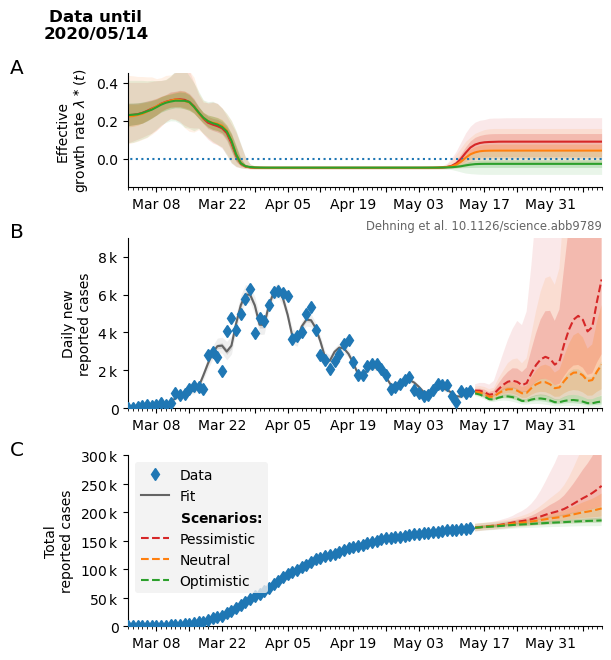

In [35]:
fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Optimistic",
    color="tab:green",
)

axes[1].set_ylim(0,9_000)
axes[2].set_ylim(0,300_000)

fig

In [36]:
%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib       : 3.6.2
pymc             : 4.4.0
sys              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
covid19_inference: 0.5.0
numpy            : 1.23.5

